In [1]:
import os
os.chdir(r"C:\Users\m3406\OneDrive\桌面\DS_Study")
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
#%% GetData
url = "https://github.com/githubjasmine/DS-A_Collection_of_Take_Home_Challenges/raw/master/INSIGHTS%20Conversion%20Rate%20with%20solution/conversion_project.csv"
df = pd.read_csv(url, parse_dates=[0])
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB




### EDA

In [ ]:
# EDA File
#report = ProfileReport(df)
#report.to_file("Conversion_Rate.html")

In [ ]:
"""
1. 0 Missing Value
2. Max Age 123 -> Drop
3. Duplicate rows 3.8%
4. Without User ID
5. conversion rate 3.2% -> imbalanced data
"""

In [4]:
# Drop observations with age > 100
print(sum(df.age>100))
df = df[df.age<100]

2


In [5]:
import matplotlib.pyplot as plt
window = 3000

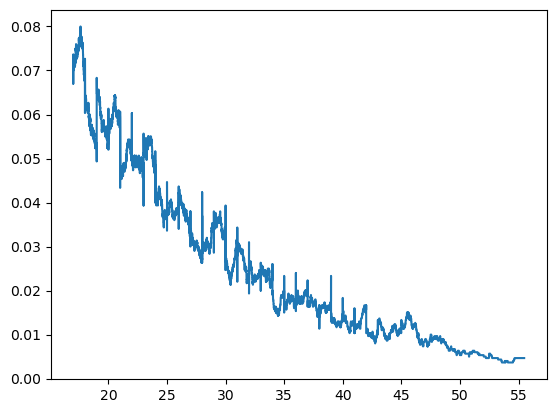

In [6]:
# AGE (Ranking )
xp = df.sort_values("age")["age"].rolling(window = window, min_periods = window, center = True).mean()
yp = (
    df.sort_values("age")["converted"].
    rolling(window = window, min_periods = window, center = True).
    apply(lambda x : sum(x)/len(x))
     )

plt.plot(xp,yp)

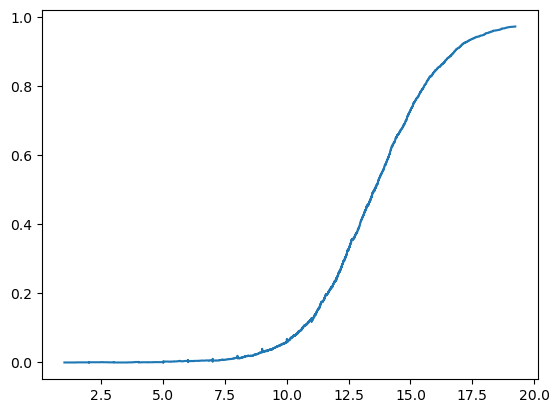

In [7]:
# Total_pages_visited
xp = df.sort_values("total_pages_visited")["total_pages_visited"].rolling(window = window, min_periods = window, center = True).mean()
yp = (
    df.sort_values("total_pages_visited")["converted"].
    rolling(window = window, min_periods = window, center = True).
    apply(lambda x : sum(x)/len(x))
    )

plt.plot(xp,yp)

<AxesSubplot:xlabel='country'>

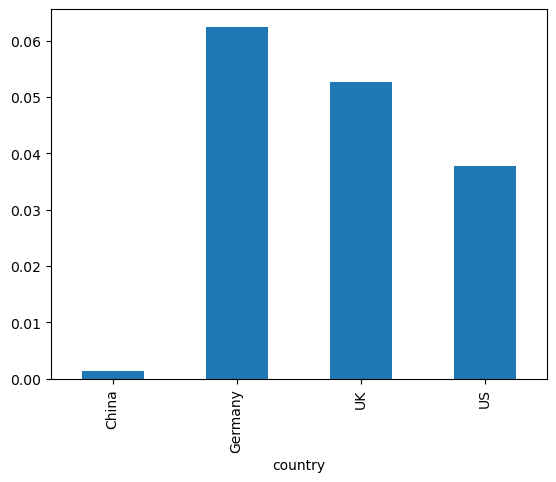

In [8]:
# Country
df[["country", "converted"]].groupby("country")["converted"].mean().plot.bar()

<AxesSubplot:xlabel='source'>

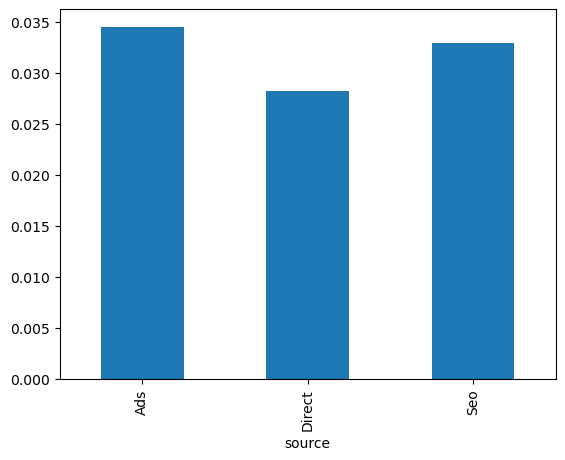

In [9]:
# Source
df[["source", "converted"]].groupby("source")["converted"].mean().plot.bar()

<AxesSubplot:xlabel='new_user'>

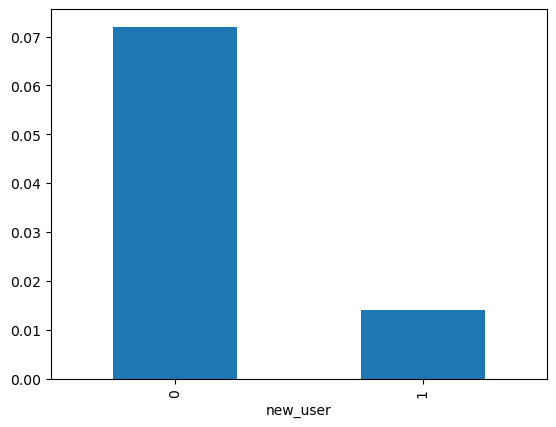

In [10]:
# New_User
df[["new_user", "converted"]].groupby("new_user")["converted"].mean().plot.bar()



### Modeling

In [11]:
from sklearn import ensemble,  metrics
from sklearn.model_selection import train_test_split

In [12]:
# Seed
RANDOM_STATE = 123

In [13]:
# One Hot Encoding
x = pd.concat([df, pd.get_dummies(df[["country", "source"]])], axis = 1).drop(["country", "converted", "source"], axis = 1)
y = df["converted"]

In [14]:
x.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [15]:
# Split Dataset 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = RANDOM_STATE)

In [16]:
# RF Modeling
Forest = ensemble.RandomForestClassifier(n_estimators = 100, oob_score = True, random_state = RANDOM_STATE)
forest_fit = Forest.fit(x_train, y_train)

train_pred, test_pred = Forest.predict(x_train), Forest.predict(x_test)

In [17]:
# Confusion Matrix
metrics.confusion_matrix(y_test, test_pred)

array([[91452,   492],
       [  954,  1962]], dtype=int64)

In [18]:
# Score
print(f"Oob Score = {100*forest_fit.oob_score_:.2f}%. ")

train_acc, test_acc = metrics.accuracy_score(y_train,  train_pred), metrics.accuracy_score(y_test,  test_pred)
print(f"Train Accuracy = {100*train_acc:.2f}%, Test Accuracy = {100*test_acc:.2f}%. ")

train_precision, test_precision = sum(train_pred*y_train)/train_pred.sum(), sum(test_pred*y_test)/test_pred.sum()
print(f"Train Precision = {100*train_precision:.2f}%, Test Precision = {100*test_precision:.2f}%. ")

train_recall, test_recall = sum(train_pred*y_train)/y_train.sum(), sum(test_pred*y_test)/y_test.sum()
print(f"Train Recall = {100*train_recall:.2f}%, Test Recall = {100*test_recall:.2f}%. ")

Oob Score = 98.42%. 
Train Accuracy = 98.83%, Test Accuracy = 98.48%. 
Train Precision = 88.67%, Test Precision = 79.95%. 
Train Recall = 73.81%, Test Recall = 67.28%. 


<AxesSubplot:>

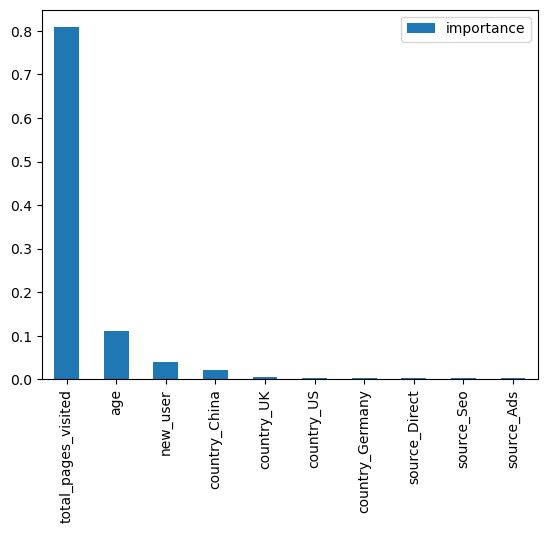

In [19]:
# Importance
df_importance = pd.DataFrame(index = Forest.feature_names_in_, columns = ["importance"],
             data = Forest.feature_importances_)
df_importance.sort_values("importance", ascending = False).plot.bar()



### Modeling without Total_pages_visited

In [ ]:
""""
Total_pages_visited is not a good indicator in real world bcuz of : 
(1) Causality Ambiguous.
(2) Not a Leading Indicator
"""

In [20]:
forest_2 = Forest.fit(x_train.drop("total_pages_visited", axis = 1), y_train)

train_pred, test_pred = Forest.predict(x_train.drop("total_pages_visited", axis = 1)), Forest.predict(x_test.drop("total_pages_visited", axis = 1))

In [21]:
# Confusion Matrix
metrics.confusion_matrix(y_test, test_pred)

array([[91944,     0],
       [ 2916,     0]], dtype=int64)

In [23]:
# Score
print(len(test_pred))
print(f"Oob Score = {100*forest_2.oob_score_}")

train_acc, test_acc = metrics.accuracy_score(y_train,  train_pred), metrics.accuracy_score(y_test,  test_pred)
print(f"Train Accuracy = {100*train_acc:.2f}%, Test Accuracy = {100*test_acc:.2f}%. ")

#train_precision, test_precision = sum(train_pred*y_train)/train_pred.sum(), sum(test_pred*y_test)/test_pred.sum()
#print(f"Train Precision = {100*train_precision:.2f}%, Test Precision = {100*test_precision:.2f}%. ")

train_recall, test_recall = sum(train_pred*y_train)/y_train.sum(), sum(test_pred*y_test)/y_test.sum()
print(f"Train Recall = {100*train_recall:.2f}%, Test Recall = {100*test_recall:.2f}%. ")

94860
Oob Score = 96.7100091263136
Train Accuracy = 96.71%, Test Accuracy = 96.93%. 
Train Recall = 0.00%, Test Recall = 0.00%. 


<AxesSubplot:>

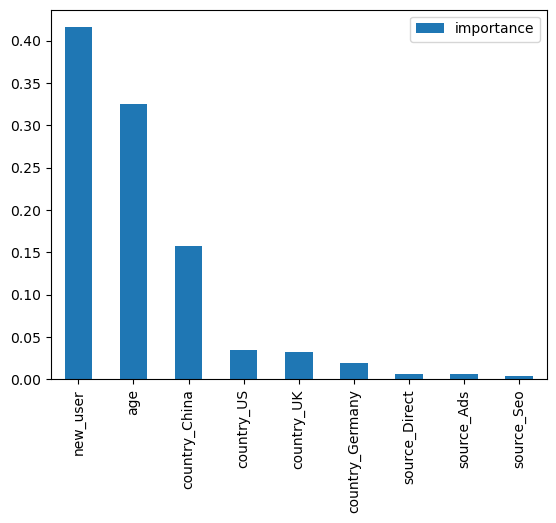

In [24]:
# Importance
df_importance = pd.DataFrame(index = Forest.feature_names_in_, columns = ["importance"],
             data = Forest.feature_importances_)
df_importance.sort_values("importance", ascending = False).plot.bar()



### Further
(1) Age 
(2) Imbalance